<a href="https://colab.research.google.com/github/ykitaguchi77/POLAR/blob/main/Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

device:cuda  batch:256  epochs:50  warmup:4  conf_thresh:0.8
[epoch 1] loss:2.0660  test_acc:0.5868
[epoch 2] loss:1.6684  test_acc:0.6774
[epoch 3] loss:1.4304  test_acc:0.7027
[epoch 4] loss:1.2747  test_acc:0.7320
[epoch 5] loss:1.1932  test_acc:0.7468
[epoch 6] loss:1.1117  test_acc:0.7605
[epoch 7] loss:1.0474  test_acc:0.7704
[epoch 8] loss:0.9956  test_acc:0.7768
[epoch 9] loss:0.9526  test_acc:0.7846
[epoch 10] loss:0.9163  test_acc:0.7905
[epoch 11] loss:0.8851  test_acc:0.7953
[epoch 12] loss:0.8580  test_acc:0.8015
[epoch 13] loss:0.8341  test_acc:0.8033
[epoch 14] loss:0.8129  test_acc:0.8090
[epoch 15] loss:0.7937  test_acc:0.8134
[epoch 16] loss:0.7765  test_acc:0.8166
[epoch 17] loss:0.7608  test_acc:0.8193
[epoch 18] loss:0.7465  test_acc:0.8216
[epoch 19] loss:0.7334  test_acc:0.8248
[epoch 20] loss:0.7212  test_acc:0.8271
[epoch 21] loss:0.7099  test_acc:0.8299
[epoch 22] loss:0.6993  test_acc:0.8321
[epoch 23] loss:0.6896  test_acc:0.8344
[epoch 24] loss:0.6804  test

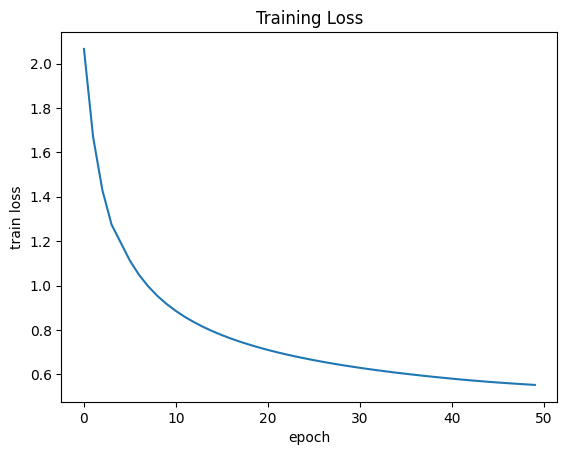

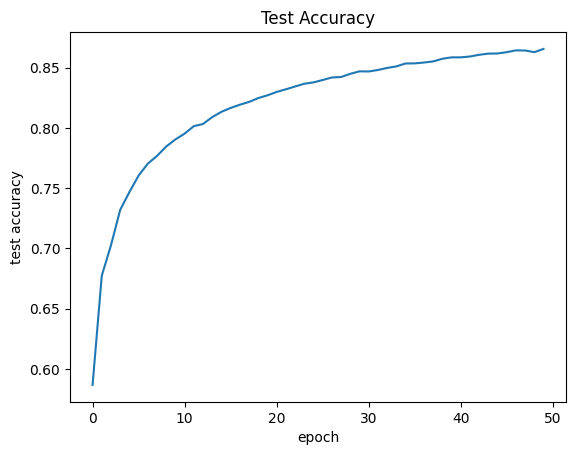

In [5]:
# @title MNIST: 逆伝播なし（プロトタイプ局所学習）安定版v3：正規化MSE + 適応ランプ + クリップ
import math, time, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ===== ハイパラ =====
use_cuda_if_available = True
epochs = 50
warmup_epochs = 4
batch_size = 256

lr_w = 2e-4                     # 中間層（小さめ）
lr_out = 1e-2                   # 出力層（強め）
proto_momentum = 0.99
lam_hidden_max = (0.2, 0.2, 0.2) # 最大係数はやや上げる（適応で自動減衰）
conf_thresh = 0.80              # 信頼度ゲート下限
clip_norm = 1.0                 # 中間層勾配クリップ（L2ノルム）

seed = 42
torch.manual_seed(seed); np.random.seed(seed)
device = "cuda" if (use_cuda_if_available and torch.cuda.is_available()) else "cpu"
torch.set_grad_enabled(False)

# ===== モデル =====
class LocalConv(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, stride=1, padding=1):
        super().__init__()
        self.W = nn.Parameter(torch.empty(out_ch, in_ch, k, k))
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))
        self.stride, self.padding = stride, padding
        self.norm = nn.GroupNorm(1, out_ch)
    def forward(self, a_prev):
        z = F.conv2d(a_prev, self.W, stride=self.stride, padding=self.padding)
        z = self.norm(z); a = F.relu(z)
        return z, a

class LocalFC(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Parameter(torch.empty(out_dim, in_dim))
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))
        self.norm = nn.LayerNorm(out_dim)
    def forward(self, a_prev):
        z = F.linear(a_prev, self.W)
        z = self.norm(z); a = F.relu(z)
        return z, a

class Net(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.conv1 = LocalConv(1, 32, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = LocalConv(32, 64, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1   = LocalFC(64*7*7, 128)
        self.out   = nn.Linear(128, n_classes, bias=False)
    def forward(self, x):
        z1, a1 = self.conv1(x); a1p = self.pool1(a1)
        z2, a2 = self.conv2(a1p); a2p = self.pool2(a2)
        a2f = a2p.reshape(a2p.size(0), -1)
        z3, a3 = self.fc1(a2f)
        logits = self.out(a3)
        return (z1, z2, z3), (x, a1, a1p, a2, a2p, a2f, a3), logits

# ===== プロトタイプ =====
class ProtoBank:
    def __init__(self, dims, n_classes=10, momentum=0.99, device="cpu"):
        self.m = momentum
        self.P = {k: torch.zeros(n_classes, d, device=device) for k, d in dims.items()}
        self.init = {k: torch.zeros(n_classes, dtype=torch.bool, device=device) for k in dims.keys()}
    @torch.no_grad()
    def _upd(self, key, feats, y):
        Pk, Ik = self.P[key], self.init[key]
        for c in y.unique():
            c0 = int(c)
            m = (y==c)
            mu = feats[m].mean(0)
            if not Ik[c0]:
                Pk[c0] = mu; Ik[c0] = True
            else:
                Pk[c0] = self.m * Pk[c0] + (1 - self.m) * mu
        return Pk[y]
    def conv_target(self, key, Z, y):
        return self._upd(key, Z.mean((2,3)), y).unsqueeze(-1).unsqueeze(-1).expand_as(Z)
    def fc_target(self, key, Z, y):
        return self._upd(key, Z, y)

# ===== 正規化MSE（scale-invariant） =====
def norm_mse(Z, U, dims):
    # L2正規化（小さすぎるノルムは抑止）
    eps = 1e-6
    if len(Z.shape)==4:  # conv: [B,C,H,W] -> 正規化はC次元で
        Zn = Z / (Z.pow(2).sum(dim=1, keepdim=True).sqrt().clamp_min(eps))
        Un = U / (U.pow(2).sum(dim=1, keepdim=True).sqrt().clamp_min(eps))
    else:                # fc: [B,D] -> D次元で
        Zn = Z / (Z.pow(2).sum(dim=1, keepdim=True).sqrt().clamp_min(eps))
        Un = U / (U.pow(2).sum(dim=1, keepdim=True).sqrt().clamp_min(eps))
    E = Zn - Un
    L = 0.5 * (E.pow(2).mean())
    return E, L

# ===== 適応ランプ（バッチ毎） =====
def adaptive_lambda(ep, warmup_epochs, lam_max, conf_mean, ce_improve):
    """
    conf_mean: そのバッチの平均 max softmax
    ce_improve: 直近のCEが改善（負なら悪化）
    """
    if ep <= warmup_epochs:
        return 0.0
    # 自信と改善が高いほど係数アップ（0〜1に収める）
    c = max(0.0, (conf_mean - 0.75) / (1.0 - 0.75))  # 0.75から1.0へ線形
    g = 1.0 if ce_improve < 0 else 0.5               # 改善時=1, 悪化時=0.5
    base = c * g
    return lam_max * base

def grad_clip_(W, G, max_norm):
    # Gのノルムでスケールダウン
    if max_norm is None or max_norm <= 0:
        return G
    gnorm = torch.linalg.vector_norm(G)
    if gnorm > max_norm:
        G = G * (max_norm / (gnorm + 1e-12))
    return G

def lambda_schedule_epoch(ep, start_ep, end_ep, max_lambda):
    if ep <= start_ep: return 0.0
    if ep >= end_ep:   return max_lambda
    t = (ep - start_ep) / max(1, (end_ep - start_ep))
    return max_lambda * t

@torch.no_grad()
def train_step(model, protos, feats, zs, y, lr_w, lr_out,
               ep, warmup_epochs, lam_hidden_max, conf_thresh,
               prev_ce_avg=None):
    (z1, z2, z3) = zs
    (x, a1, a1p, a2, a2p, a2f, a3) = feats

    # --- 出力層: CE（手動勾配） ---
    logits = model.out(a3)
    prob = F.softmax(logits, dim=1)
    onehot = F.one_hot(y, num_classes=logits.shape[1]).float().to(logits.device)
    ce_val = F.cross_entropy(logits, y).item()
    grad_logits = (prob - onehot) / logits.shape[0]
    dW_out = grad_logits.T @ a3
    model.out.weight.data.add_(-lr_out * dW_out)

    # プロトタイプ更新（常時）
    _ = protos.conv_target("c1", z1, y)
    _ = protos.conv_target("c2", z2, y)
    _ = protos.fc_target ("fc1", z3, y)

    if ep <= warmup_epochs:
        return ce_val, logits, ce_val  # ce_avgを返して次バッチの比較に使う

    # バッチ信頼度とCE改善
    conf_mean = prob.max(1).values.mean().item()
    ce_improve = ce_val - (prev_ce_avg if prev_ce_avg is not None else ce_val)

    # 各層の適応係数（エポックRamp × バッチ適応）
    lam1_max = lambda_schedule_epoch(ep, warmup_epochs, warmup_epochs+3, lam_hidden_max[0])
    lam2_max = lambda_schedule_epoch(ep, warmup_epochs, warmup_epochs+3, lam_hidden_max[1])
    lam3_max = lambda_schedule_epoch(ep, warmup_epochs, warmup_epochs+3, lam_hidden_max[2])
    lam1 = adaptive_lambda(ep, warmup_epochs, lam1_max, conf_mean, ce_improve)
    lam2 = adaptive_lambda(ep, warmup_epochs, lam2_max, conf_mean, ce_improve)
    lam3 = adaptive_lambda(ep, warmup_epochs, lam3_max, conf_mean, ce_improve)

    # 信頼度ゲート（サンプル選別）
    conf = prob.max(dim=1).values
    mask = (conf >= conf_thresh).float()
    if mask.sum() < 1:
        return ce_val, logits, (0.9*prev_ce_avg + 0.1*ce_val) if prev_ce_avg is not None else ce_val
    mask_c1 = mask.view(-1,1,1,1); mask_c2 = mask.view(-1,1,1,1); mask_fc = mask.view(-1,1)

    # conv1（入力は x）: 正規化MSE
    U1 = protos.conv_target("c1", z1, y)
    E1n, L1 = norm_mse(z1, U1, dims=(0,2,3))
    E1n = E1n * mask_c1
    dW1 = torch.nn.grad.conv2d_weight(x, model.conv1.W.shape, (lam1 * E1n) / max(1, int(mask.sum())),
                                      stride=model.conv1.stride, padding=model.conv1.padding)
    dW1 = grad_clip_(model.conv1.W, dW1, clip_norm)
    model.conv1.W.add_(-lr_w * dW1)

    # conv2（入力は a1p）: 正規化MSE
    U2 = protos.conv_target("c2", z2, y)
    E2n, L2 = norm_mse(z2, U2, dims=(0,2,3))
    E2n = E2n * mask_c2
    dW2 = torch.nn.grad.conv2d_weight(a1p, model.conv2.W.shape, (lam2 * E2n) / max(1, int(mask.sum())),
                                      stride=model.conv2.stride, padding=model.conv2.padding)
    dW2 = grad_clip_(model.conv2.W, dW2, clip_norm)
    model.conv2.W.add_(-lr_w * dW2)

    # fc1: 正規化MSE
    U3 = protos.fc_target("fc1", z3, y)
    E3n, L3 = norm_mse(z3, U3, dims=(0,))
    E3n = E3n * mask_fc
    dW3 = ((lam3 * E3n) / max(1, int(mask.sum()))).T @ a2f
    dW3 = grad_clip_(model.fc1.W, dW3, clip_norm)
    model.fc1.W.add_(-lr_w * dW3)

    total = ce_val + L1.item() + L2.item() + L3.item()
    ce_avg = (0.9*prev_ce_avg + 0.1*ce_val) if prev_ce_avg is not None else ce_val
    return total, logits, ce_avg

def eval_accuracy(model, loader, device):
    correct = total = 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        _, _, logits = model(x)
        pred = logits.argmax(1)
        correct += (pred.cpu() == y).sum().item()
        total += y.size(0)
    return correct / total

# ===== データ =====
tfm = transforms.ToTensor()
train_ds = datasets.MNIST(root="/content/data", train=True, download=True, transform=tfm)
test_ds  = datasets.MNIST(root="/content/data", train=False, download=True, transform=tfm)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2,
                          pin_memory=(device=="cuda"))
test_loader  = DataLoader(test_ds, batch_size=512, shuffle=False, num_workers=2,
                          pin_memory=(device=="cuda"))

# ===== 準備 =====
n_classes = 10
model = Net(n_classes=n_classes).to(device)
protos = ProtoBank({"c1":32,"c2":64,"fc1":128}, n_classes=n_classes, momentum=proto_momentum, device=device)

# ===== 学習 =====
hist = {"train_loss": [], "test_acc": []}
print(f"device:{device}  batch:{batch_size}  epochs:{epochs}  warmup:{warmup_epochs}  conf_thresh:{conf_thresh}")
t0 = time.time()
ce_avg = None
for ep in range(1, epochs+1):
    running_loss, n = 0.0, 0
    for x, y in train_loader:
        x = x.to(device, non_blocking=True); y = y.to(device)
        zs, feats, logits = model(x)
        loss_batch, _, ce_avg = train_step(
            model, protos, feats, zs, y,
            lr_w=lr_w, lr_out=lr_out,
            ep=ep, warmup_epochs=warmup_epochs,
            lam_hidden_max=lam_hidden_max, conf_thresh=conf_thresh,
            prev_ce_avg=ce_avg
        )
        running_loss += loss_batch * x.size(0); n += x.size(0)
    train_loss = running_loss / n
    test_acc = eval_accuracy(model, test_loader, device)
    hist["train_loss"].append(train_loss); hist["test_acc"].append(test_acc)
    print(f"[epoch {ep}] loss:{train_loss:.4f}  test_acc:{test_acc:.4f}")

print(f"done. elapsed: {time.time()-t0:.1f}s")

plt.figure(); plt.plot(hist["train_loss"]); plt.xlabel("epoch"); plt.ylabel("train loss"); plt.title("Training Loss"); plt.show()
plt.figure(); plt.plot(hist["test_acc"]); plt.xlabel("epoch"); plt.ylabel("test accuracy"); plt.title("Test Accuracy"); plt.show()


In [ ]:
# MNIST: 逆伝播なし（プロトタイプ局所学習）安定版 v4
import math, time, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ===== ハイパラ =====
use_cuda_if_available = True
epochs = 50
warmup_epochs = 4
batch_size = 256

lr_w = 2e-4                     # 中間層（小さめ）
lr_out = 1e-2                   # 出力層（強め）
proto_momentum = 0.99
lam_hidden_max = (0.2, 0.2, 0.2)
conf_thresh = 0.80              # 信頼度ゲート
cos_thresh = 0.20               # 追加: プロトタイプとのcos類似度ゲート（0〜1）。0.2〜0.4が目安
clip_norm = 1.0                 # 中間層勾配クリップ（L2ノルム）
temp_eval = 1.2                 # 追加: 評価時の温度（過信抑制）
use_ema_eval = True             # 追加: EMAで評価

seed = 42
torch.manual_seed(seed); np.random.seed(seed)
device = "cuda" if (use_cuda_if_available and torch.cuda.is_available()) else "cpu"
torch.set_grad_enabled(False)
# （必要なら）再現性を高める
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# ===== モデル =====
class LocalConv(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, stride=1, padding=1):
        super().__init__()
        self.W = nn.Parameter(torch.empty(out_ch, in_ch, k, k))
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))
        self.stride, self.padding = stride, padding
        self.norm = nn.GroupNorm(1, out_ch)
    def forward(self, a_prev):
        z_pre = F.conv2d(a_prev, self.W, stride=self.stride, padding=self.padding)
        z = self.norm(z_pre)
        a = F.relu(z)
        return z, a

class LocalFC(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Parameter(torch.empty(out_dim, in_dim))
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))
        self.norm = nn.LayerNorm(out_dim)
    def forward(self, a_prev):
        z_pre = F.linear(a_prev, self.W)
        z = self.norm(z_pre)
        a = F.relu(z)
        return z, a

class Net(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.conv1 = LocalConv(1, 32, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = LocalConv(32, 64, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1   = LocalFC(64*7*7, 128)
        self.out   = nn.Linear(128, n_classes, bias=False)
    def forward(self, x):
        z1, a1 = self.conv1(x); a1p = self.pool1(a1)
        z2, a2 = self.conv2(a1p); a2p = self.pool2(a2)
        a2f = a2p.reshape(a2p.size(0), -1)
        z3, a3 = self.fc1(a2f)
        logits = self.out(a3)
        return (z1, z2, z3), (x, a1, a1p, a2, a2p, a2f, a3), logits

# ===== プロトタイプ =====
class ProtoBank:
    def __init__(self, dims, n_classes=10, momentum=0.99, device="cpu"):
        self.m = momentum
        self.P = {k: torch.zeros(n_classes, d, device=device) for k, d in dims.items()}
        self.init = {k: torch.zeros(n_classes, dtype=torch.bool, device=device) for k in dims.keys()}
    @torch.no_grad()
    def _upd(self, key, feats, y):
        Pk, Ik = self.P[key], self.init[key]
        for c in y.unique():
            c0 = int(c)
            m = (y==c)
            mu = feats[m].mean(0)
            if not Ik[c0]:
                Pk[c0] = mu; Ik[c0] = True
            else:
                Pk[c0] = self.m * Pk[c0] + (1 - self.m) * mu
        return Pk[y]
    def conv_target(self, key, Z, y):
        return self._upd(key, Z.mean((2,3)), y).unsqueeze(-1).unsqueeze(-1).expand_as(Z)
    def fc_target(self, key, Z, y):
        return self._upd(key, Z, y)

# ===== 正規化MSE（scale-invariant） + ReLU近似勾配 =====
def norm_mse_with_relu_mask(Z, U, z_for_mask):
    eps = 1e-6
    if Z.ndim == 4:
        Zn = Z / (Z.pow(2).sum(dim=1, keepdim=True).sqrt().clamp_min(eps))
        Un = U / (U.pow(2).sum(dim=1, keepdim=True).sqrt().clamp_min(eps))
        relu_mask = (z_for_mask > 0).float()
    else:
        Zn = Z / (Z.pow(2).sum(dim=1, keepdim=True).sqrt().clamp_min(eps))
        Un = U / (U.pow(2).sum(dim=1, keepdim=True).sqrt().clamp_min(eps))
        relu_mask = (z_for_mask > 0).float()
    E = (Zn - Un) * relu_mask
    L = 0.5 * (E.pow(2).mean())
    return E, L

# ===== 適応ランプ（バッチ毎） =====
def adaptive_lambda(ep, warmup_epochs, lam_max, conf_mean, ce_improve):
    if ep <= warmup_epochs:
        return 0.0
    c = max(0.0, (conf_mean - 0.75) / (1.0 - 0.75))
    g = 1.0 if ce_improve < 0 else 0.5
    base = c * g
    return lam_max * base

def grad_clip_(G, max_norm):
    if max_norm is None or max_norm <= 0:
        return G
    gnorm = torch.linalg.vector_norm(G)
    if gnorm > max_norm:
        G = G * (max_norm / (gnorm + 1e-12))
    return G

def lambda_schedule_epoch(ep, start_ep, end_ep, max_lambda):
    if ep <= start_ep: return 0.0
    if ep >= end_ep:   return max_lambda
    t = (ep - start_ep) / max(1, (end_ep - start_ep))
    return max_lambda * t

@torch.no_grad()
def cosine_similarity(a, b, dim=1, eps=1e-8):
    an = a / (a.norm(dim=dim, keepdim=True).clamp_min(eps))
    bn = b / (b.norm(dim=dim, keepdim=True).clamp_min(eps))
    return (an * bn).sum(dim=dim)

@torch.no_grad()
def train_step(model, protos, feats, zs, y, lr_w, lr_out,
               ep, warmup_epochs, lam_hidden_max, conf_thresh, cos_thresh,
               prev_ce_avg=None):
    (z1, z2, z3) = zs
    (x, a1, a1p, a2, a2p, a2f, a3) = feats

    # --- 出力層: CE（手動勾配） ---
    logits = model.out(a3)                 # ここでのみ使用（更新は直後）
    prob = F.softmax(logits, dim=1)
    onehot = F.one_hot(y, num_classes=logits.shape[1]).float().to(logits.device)
    ce_val = F.cross_entropy(logits, y).item()
    grad_logits = (prob - onehot) / logits.shape[0]
    dW_out = grad_logits.T @ a3
    model.out.weight.data.add_(-lr_out * dW_out)

    # プロトタイプ更新（常時）
    U1 = protos.conv_target("c1", z1, y)
    U2 = protos.conv_target("c2", z2, y)
    U3 = protos.fc_target ("fc1", z3, y)

    if ep <= warmup_epochs:
        return ce_val, logits, ce_val

    # バッチ信頼度＆CE改善
    conf_mean = prob.max(1).values.mean().item()
    ce_improve = ce_val - (prev_ce_avg if prev_ce_avg is not None else ce_val)

    # エポックRamp × バッチ適応
    lam1_max = lambda_schedule_epoch(ep, warmup_epochs, warmup_epochs+3, lam_hidden_max[0])
    lam2_max = lambda_schedule_epoch(ep, warmup_epochs, warmup_epochs+3, lam_hidden_max[1])
    lam3_max = lambda_schedule_epoch(ep, warmup_epochs, warmup_epochs+3, lam_hidden_max[2])
    lam1 = adaptive_lambda(ep, warmup_epochs, lam1_max, conf_mean, ce_improve)
    lam2 = adaptive_lambda(ep, warmup_epochs, lam2_max, conf_mean, ce_improve)
    lam3 = adaptive_lambda(ep, warmup_epochs, lam3_max, conf_mean, ce_improve)

    # --- 二重ゲート: softmax信頼度 + cos類似度 ---
    with torch.no_grad():
        conf = prob.max(dim=1).values
        cos1 = cosine_similarity(z1.mean((2,3)), U1.mean((2,3)), dim=1)
        cos2 = cosine_similarity(z2.mean((2,3)), U2.mean((2,3)), dim=1)
        cos3 = cosine_similarity(z3,              U3,               dim=1)
        cos_ok = ((cos1 > cos_thresh) & (cos2 > cos_thresh) & (cos3 > cos_thresh)).float()
        mask = ((conf >= conf_thresh).float() * cos_ok)
    if mask.sum() < 1:
        ce_avg = (0.9*prev_ce_avg + 0.1*ce_val) if prev_ce_avg is not None else ce_val
        return ce_val, logits, ce_avg

    mask_c = mask.view(-1,1,1,1)
    mask_fc = mask.view(-1,1)

    # --- conv1 更新（ReLU近似マスク入り正規化MSE）
    E1n, L1 = norm_mse_with_relu_mask(z1, U1, z_for_mask=z1)
    E1n = E1n * mask_c
    grad_like_1 = (lam1 * E1n) / max(1, int(mask.sum()))
    dW1 = torch.nn.grad.conv2d_weight(x, model.conv1.W.shape, grad_like_1,
                                      stride=model.conv1.stride, padding=model.conv1.padding)
    dW1 = grad_clip_(dW1, clip_norm)
    model.conv1.W.add_(-lr_w * dW1)

    # --- conv2 更新
    E2n, L2 = norm_mse_with_relu_mask(z2, U2, z_for_mask=z2)
    E2n = E2n * mask_c
    grad_like_2 = (lam2 * E2n) / max(1, int(mask.sum()))
    dW2 = torch.nn.grad.conv2d_weight(a1p, model.conv2.W.shape, grad_like_2,
                                      stride=model.conv2.stride, padding=model.conv2.padding)
    dW2 = grad_clip_(dW2, clip_norm)
    model.conv2.W.add_(-lr_w * dW2)

    # --- fc1 更新
    E3n, L3 = norm_mse_with_relu_mask(z3, U3, z_for_mask=z3)
    E3n = E3n * mask_fc
    dW3 = ((lam3 * E3n) / max(1, int(mask.sum()))).T @ a2f
    dW3 = grad_clip_(dW3, clip_norm)
    model.fc1.W.add_(-lr_w * dW3)

    total = ce_val + L1.item() + L2.item() + L3.item()
    ce_avg = (0.9*prev_ce_avg + 0.1*ce_val) if prev_ce_avg is not None else ce_val
    return total, logits, ce_avg

# ===== EMA モデル =====
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = [p.detach().clone() for p in model.parameters()]
        self.params = [p for p in model.parameters()]
    @torch.no_grad()
    def update(self):
        for s, p in zip(self.shadow, self.params):
            s.mul_(self.decay).add_(p, alpha=(1.0 - self.decay))
    @torch.no_grad()
    def to_model(self, model):
        for s, p in zip(self.shadow, model.parameters()):
            p.copy_(s)

@torch.inference_mode()
def eval_accuracy(model, loader, device, T=1.0):
    correct = total = 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        _, _, logits = model(x)
        if T != 1.0:
            logits = logits / T
        pred = logits.argmax(1).cpu()
        correct += (pred == y).sum().item()
        total += y.size(0)
    return correct / total

# ===== データ =====
tfm = transforms.ToTensor()
train_ds = datasets.MNIST(root="/content/data", train=True, download=True, transform=tfm)
test_ds  = datasets.MNIST(root="/content/data", train=False, download=True, transform=tfm)
pinmem = (device=="cuda")
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=pinmem)
test_loader  = DataLoader(test_ds,  batch_size=512,    shuffle=False, num_workers=2, pin_memory=pinmem)

# ===== 準備 =====
n_classes = 10
model = Net(n_classes=n_classes).to(device)
ema = EMA(model, decay=0.999) if use_ema_eval else None
protos = ProtoBank({"c1":32,"c2":64,"fc1":128}, n_classes=n_classes, momentum=proto_momentum, device=device)

# ===== 学習 =====
hist = {"train_loss": [], "test_acc": []}
print(f"device:{device}  batch:{batch_size}  epochs:{epochs}  warmup:{warmup_epochs}  conf_thresh:{conf_thresh}  cos_thresh:{cos_thresh}")
t0 = time.time()
ce_avg = None
for ep in range(1, epochs+1):
    running_loss, n = 0.0, 0
    for x, y in train_loader:
        x = x.to(device, non_blocking=True); y = y.to(device)
        zs, feats, _ = model(x)
        loss_batch, _, ce_avg = train_step(
            model, protos, feats, zs, y,
            lr_w=lr_w, lr_out=lr_out,
            ep=ep, warmup_epochs=warmup_epochs,
            lam_hidden_max=lam_hidden_max, conf_thresh=conf_thresh, cos_thresh=cos_thresh,
            prev_ce_avg=ce_avg
        )
        running_loss += loss_batch * x.size(0); n += x.size(0)
        if use_ema_eval: ema.update()
    train_loss = running_loss / n

    # 評価は EMA（あれば）＋ 温度スケーリング
    if use_ema_eval:
        backup = [p.detach().clone() for p in model.parameters()]
        ema.to_model(model)
        test_acc = eval_accuracy(model, test_loader, device, T=temp_eval)
        # 元に戻す
        for p, b in zip(model.parameters(), backup): p.copy_(b)
    else:
        test_acc = eval_accuracy(model, test_loader, device, T=temp_eval)

    hist["train_loss"].append(train_loss); hist["test_acc"].append(test_acc)
    print(f"[epoch {ep}] loss:{train_loss:.4f}  test_acc:{test_acc:.4f}")

print(f"done. elapsed: {time.time()-t0:.1f}s")

plt.figure(); plt.plot(hist["train_loss"]); plt.xlabel("epoch"); plt.ylabel("train loss"); plt.title("Training Loss"); plt.show()
plt.figure(); plt.plot(hist["test_acc"]); plt.xlabel("epoch"); plt.ylabel("test accuracy"); plt.title("Test Accuracy"); plt.show()


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.23MB/s]


device:cuda  batch:256  epochs:50  warmup:4  conf_thresh:0.8  cos_thresh:0.2
[epoch 1] loss:2.0660  test_acc:0.1253
[epoch 2] loss:1.6684  test_acc:0.3004
[epoch 3] loss:1.4304  test_acc:0.5018
[epoch 4] loss:1.2747  test_acc:0.6104
[epoch 5] loss:1.1893  test_acc:0.6739
[epoch 6] loss:1.1077  test_acc:0.7100
[epoch 7] loss:1.0434  test_acc:0.7326
[epoch 8] loss:0.9916  test_acc:0.7484
[epoch 9] loss:0.9486  test_acc:0.7596
[epoch 10] loss:0.9123  test_acc:0.7669
[epoch 11] loss:0.8811  test_acc:0.7741
[epoch 12] loss:0.8540  test_acc:0.7824
[epoch 13] loss:0.8301  test_acc:0.7890
[epoch 14] loss:0.8089  test_acc:0.7935
[epoch 15] loss:0.7897  test_acc:0.7970
[epoch 16] loss:0.7725  test_acc:0.8022
[epoch 17] loss:0.7568  test_acc:0.8064
[epoch 18] loss:0.7425  test_acc:0.8106
[epoch 19] loss:0.7294  test_acc:0.8143
[epoch 20] loss:0.7172  test_acc:0.8166
[epoch 21] loss:0.7059  test_acc:0.8193
[epoch 22] loss:0.6953  test_acc:0.8226
[epoch 23] loss:0.6856  test_acc:0.8253
[epoch 24] l